<a href="https://colab.research.google.com/github/MichaelZhao21/stickerinator/blob/master/stickerinator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Add Margins Function

This will take in an image and add a 5% margin based on the most common color in the 4 corners (the background color). The inputs of this block can be any image type and will output images with `exp-` appended to the name.

In [53]:
import math
from PIL import Image, ImageFilter
import numpy as np

# Create output dir
!mkdir margins

def add_margin(filename):
    # Read in the image file
    im = Image.open(filename).convert('RGB')
    ima = np.array(im)

    # Apply a gaussian blur using 1% of the pixels (this number must be odd w/ min of 1)
    blur_px = max(round(min(im.size[0], im.size[1]) * 0.01), 1);
    imb = im.filter(ImageFilter.GaussianBlur(radius=2))
    imba = np.array(imb)

    # Show images
    print('Original image dims:', im.size[1], 'x', im.size[0])
    print('Blurred with', blur_px, 'x', blur_px, 'Gaussian filter')

    # Utility function to round to the 10s place
    round_tens = np.vectorize(lambda x: round(x / 10) * 10)
    ceil_tens = np.vectorize(lambda x: min(math.ceil(x / 10) * 10, 250))

    # Calculate how many pixels to get (~5% of the length of the shortest side)
    width = im.size[0]
    height = im.size[1]
    px = round(min(width, height) * 0.05)
    csz = px * px

    # Get corners, where corners are stored in clockwise order starting from the top left
    corners = np.zeros((4, px, px, 3))
    corners[0] = imba[:px, :px]
    corners[1] = imba[:px, -px:]
    corners[2] = imba[-px:, :px]
    corners[3] = imba[-px:, -px:]

    # We first want to store all counts of color values in a dictionary
    # Rounding the values to the tens place allows for us to correct for slight changes in color
    # If there is a color that has a majority in the dictionary, it is probably the background color
    corner_list = np.reshape(corners, (px * px * 4, 3))
    rounded_corner_list = ceil_tens(corner_list)
    corner_dict = {}
    for item in rounded_corner_list:
        item_t = tuple(item)
        if item_t in corner_dict.keys():
            corner_dict[item_t] = corner_dict[item_t] + 1
        else:
            corner_dict[item_t] = 1

    # Sort the dictionary to get the most common color among all these pixels
    corner_dict_sorted = dict(
        sorted(corner_dict.items(), key=lambda item: -item[1]))
    color_list = list(corner_dict_sorted.keys())
    bg = color_list[0]

    color_img = np.empty((40, 40, 3), np.uint8)
    color_img[:, :] = bg

    clist_img = np.empty((20, 20 * len(color_list), 3), np.uint8)
    for i, val in enumerate(color_list):
        clist_img[:, (i*20):((i+1)*20)] = val

    print('Approx corner color counts:', corner_dict_sorted)
    display(Image.fromarray(clist_img))
    print('\nMost common (probably background) color:', bg)
    display(Image.fromarray(color_img))

    # Expand the edges of the image by 10% of the longest edge with the background
    # color as the fill color.
    mg = round(max(width, height) * 0.1)
    exp_img = np.full((height+(2*mg), width+(2*mg), 3), bg, np.float32)
    exp_img[mg:(height+mg),mg:(width+mg)] = ima
    ei = Image.fromarray((exp_img).astype(np.uint8))

    print('\nAdded', mg, 'pixel margin to edges:')
    display(ei)

    # Save
    ei.save(f'margins/exp-{filename}')

mkdir: cannot create directory ‘margins’: File exists


# Remove Background, Add Border, and Crop (Process Image) Function

In [139]:
from PIL import Image, ImageDraw
import numpy as np
import re

# Create output dir
!mkdir processed

def process_img(filename, add_border, crop, threshold=150):
    # Read in the image file
    im = Image.open(filename).convert('RGB')

    # Floodfill op
    print('\nCreating image mask...')
    ImageDraw.floodfill(im, xy=(10, 10), value=(255, 0, 255), thresh=threshold)

    # Mask
    am = np.array(im)
    am[(am[:, :, 0:3] != [255, 0, 255]).any(2)] = [0, 255, 0]
    mask = Image.fromarray(am)
    print('Finished image mask!')
    display(mask)

    if add_border:
        # Border checking function
        maa = [255, 0, 255]
        is_border = lambda r, c: (am[r, c] != maa).any() and ((am[r-1, c] == maa).all() or (am[r, c+1] == maa).all() or (am[r+1, c] == maa).all() or (am[r, c-1] == maa).all())

        # Find and draw borders on mask
        da = np.zeros(am.shape)
        draw = ImageDraw.Draw(mask)
        RAD = 8 # Border radius
        print('\nAdding borders on mask... Done with row ', end='')
        for r in range(1, am.shape[0] - 1):
            for c in range(1, am.shape[1] - 1):
                if is_border(r, c):
                    draw.ellipse((c-RAD,r-RAD,c+RAD,r+RAD), (0,255,0), None)
            print(r, end=' | ')
        print('\nFinished adding borders on mask!')

    # Overlay the adjusted mask onto the original mask if borders were added
    if add_border:
        # Add the 2 masks together
        print('\nCombining masks...')
        ma = np.array(mask)
        ma = ma + am

        # Fix overflowed color values to 255
        fix = lambda x : 255 if x > 0 else 0
        fixv = np.vectorize(fix)
        bma = fixv(ma)

        # Overwrite bm and display
        mask = Image.fromarray(bma.astype(np.uint8))
        print('Finished image overlay with borders!')
        display(mask)

    # Apply mask to original image
    print('\nApplying mask to original image...')
    im.putalpha(255)
    imm = np.array(im)
    bma = np.array(mask)
    imm[(bma[:, :, 0:3] == [255, 255, 255]).all(2)] = [255, 255, 255, 255]
    imm[(bma[:, :, 0:3] == [255, 0, 255]).all(2)] = [0, 0, 0, 0]
    print('Finished masking original image!')
    fim = Image.fromarray(imm)

    # Crop the image
    if crop:
        # Get the max/min x/y of the image
        maa = [255, 0, 255]
        maxh, maxw, minh, minw = 0, 0, am.shape[0], am.shape[1]
        print('\nGetting image bounds...')
        for r in range(1, am.shape[0] - 1):
            for c in range(1, am.shape[1] - 1):
                if (bma[r, c] != maa).any():
                    if maxh < r:
                        maxh = r
                    if minh > r:
                        minh = r
                    if maxw < c:
                        maxw = c
                    if minw > c:
                        minw = c
        
        # Add 5% margin to the base crop
        mg = round(max(maxw - minw, maxh - minh) * 0.05)
        print(f'Image bounds are (x, y): ({minw}, {minh}) to ({maxw}, {maxh})')
        print('Cropping to bounds with', mg, 'px margin...')
        minw = max(0, minw - mg)
        minh = max(0, minh - mg)
        maxw = min(am.shape[1], maxw + mg)
        maxh = min(am.shape[0], maxh + mg)

        # Actually crop the image
        print('Cropping bounds (x, y, dx, dy):', (minw, minh, maxw - minw, maxh - minh))
        fim = fim.crop((minw, minh, maxw, maxh))
        print('Finished cropping image! Cropped size:', fim.size)
    
    # Save final image
    display(fim)
    fn_no_ext = re.sub('\..*$', '', filename)
    fn_no_ext_pre = re.sub('^.*-', '', fn_no_ext)
    fim.save(f'processed/done-{fn_no_ext_pre}.png')

mkdir: cannot create directory ‘processed’: File exists


# Runner

Make sure to initialize the functions above before running!

Original image dims: 420 x 400
Blurred with 4 x 4 Gaussian filter
Approx corner color counts: {(250, 250, 250): 1600}



Most common (probably background) color: (250, 250, 250)


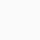


Added 42 pixel margin to edges:


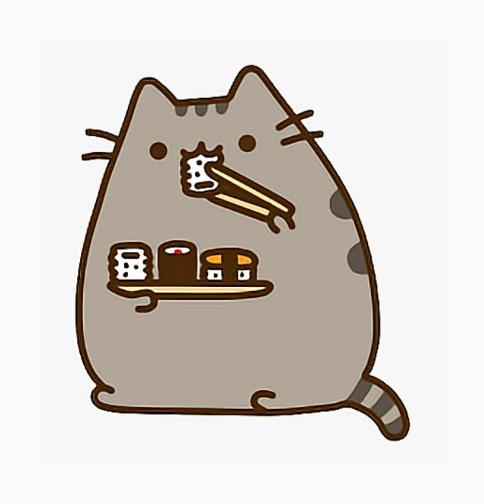


Creating image mask...
Finished image mask!


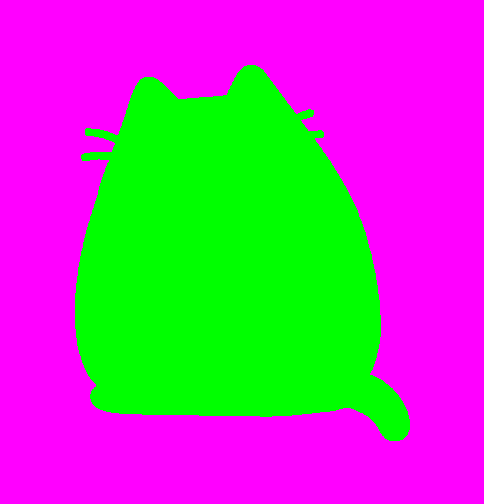


Adding borders on mask... Done with row 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 | 30 | 31 | 32 | 33 | 34 | 35 | 36 | 37 | 38 | 39 | 40 | 41 | 42 | 43 | 44 | 45 | 46 | 47 | 48 | 49 | 50 | 51 | 52 | 53 | 54 | 55 | 56 | 57 | 58 | 59 | 60 | 61 | 62 | 63 | 64 | 65 | 66 | 67 | 68 | 69 | 70 | 71 | 72 | 73 | 74 | 75 | 76 | 77 | 78 | 79 | 80 | 81 | 82 | 83 | 84 | 85 | 86 | 87 | 88 | 89 | 90 | 91 | 92 | 93 | 94 | 95 | 96 | 97 | 98 | 99 | 100 | 101 | 102 | 103 | 104 | 105 | 106 | 107 | 108 | 109 | 110 | 111 | 112 | 113 | 114 | 115 | 116 | 117 | 118 | 119 | 120 | 121 | 122 | 123 | 124 | 125 | 126 | 127 | 128 | 129 | 130 | 131 | 132 | 133 | 134 | 135 | 136 | 137 | 138 | 139 | 140 | 141 | 142 | 143 | 144 | 145 | 146 | 147 | 148 | 149 | 150 | 151 | 152 | 153 | 154 | 155 | 156 | 157 | 158 | 159 | 160 | 161 | 162 | 163 | 164 | 165 | 166 | 167 | 168 | 169 | 170 | 171 | 172 | 173 | 174 | 175 | 176 | 177 | 178 |

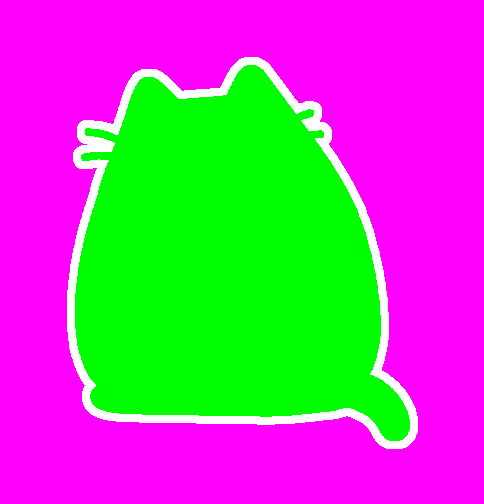


Applying mask to original image...
Finished masking original image!

Getting image bounds...
Image bounds are (x, y): (67, 57) to (417, 448)
Cropping to bounds with 20 px margin...
Cropping bounds (x, y, dx, dy): (47, 37, 390, 431)
Finished cropping image! Cropped size: (390, 431)


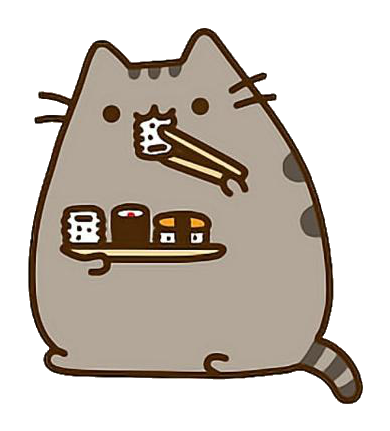

In [143]:
# Input file name
FILE_NAME = 'pusheen.jpg'

# Add a margin to the input file
add_margin(FILE_NAME)

# Process the image
# The last 3 parameters are options that can be changed
process_img(f'margins/exp-{FILE_NAME}', add_border=True, crop=True, threshold=150)